In [129]:
pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
pip install textblob

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1


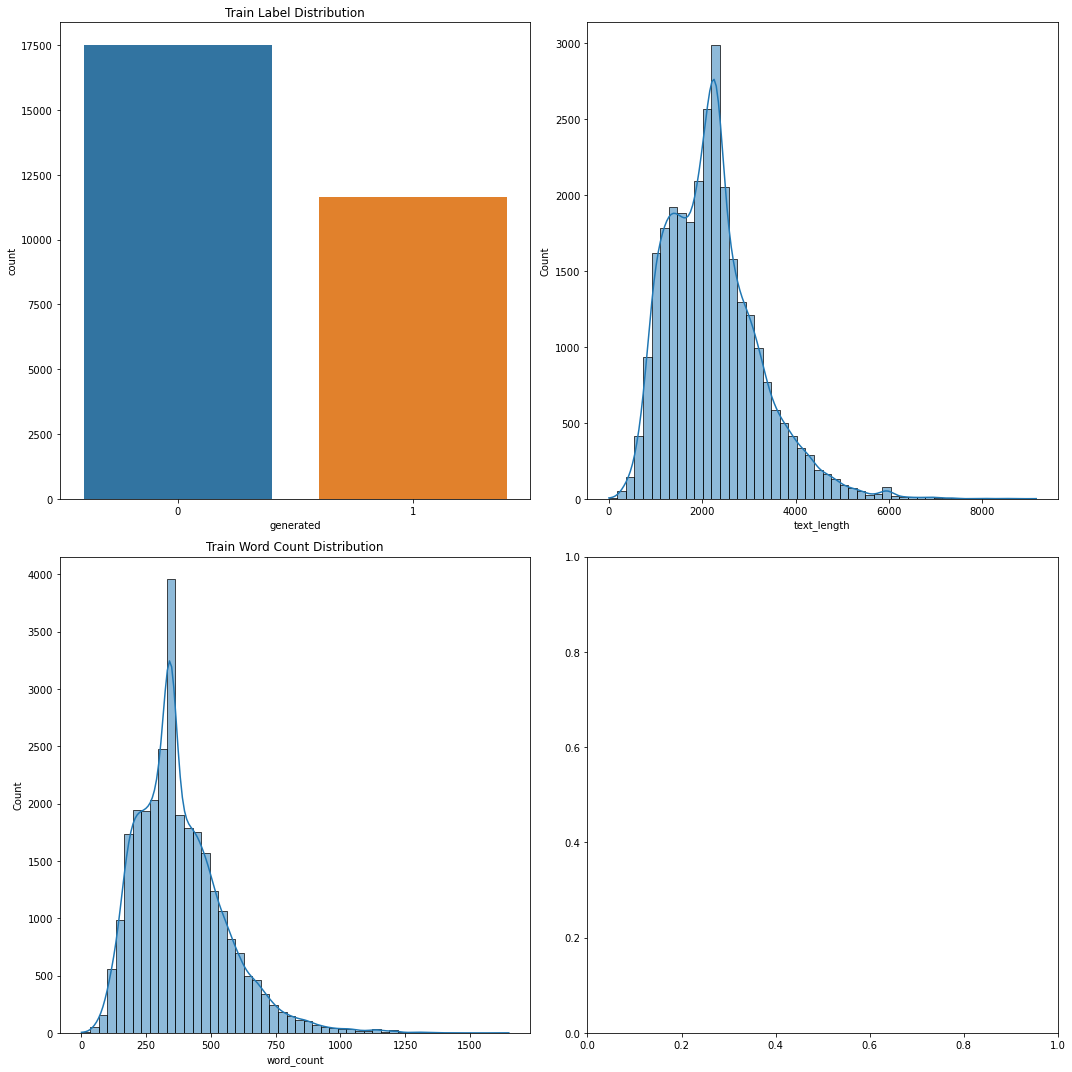

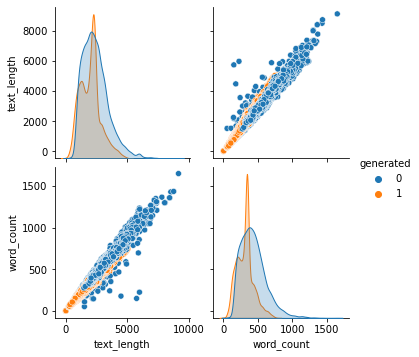

   generated  text_length_mean  text_length_std  text_length_min  \
0          0       2403.213160      1041.395003              239   
1          1       1984.401908       839.414973                1   

   text_length_max  word_count_mean  word_count_std  word_count_min  \
0             9157       430.179518      183.115058              48   
1             5078       312.379823      123.200536               1   

   word_count_max  
0            1650  
1             785  


In [132]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.util import ngrams
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
pd.set_option('display.max_columns', None)


train_path = '../dataset/Training_Essay_Data.csv'

train_df = pd.read_csv(train_path)
print(train_df.head())
train_size = train_df.shape
train_missing_values = train_df.isnull().sum()
train_label_distribution = train_df['generated'].value_counts()

# Adding text length and word count columns
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

text_length_info_train = train_df['text_length'].describe()
word_count_info_train = train_df['word_count'].describe()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# Label distribution
sns.countplot(ax=axes[0, 0], x='generated', data=train_df)
axes[0, 0].set_title('Train Label Distribution')

# Text length distribution
sns.histplot(ax=axes[0, 1], x='text_length', data=train_df, bins=50, kde=True)
axes[1, 0].set_title('Train Text Length Distribution')

sns.histplot(ax=axes[1, 0], x='word_count', data=train_df, bins=50, kde=True)
axes[1, 0].set_title('Train Word Count Distribution')

plt.tight_layout()
plt.show()

sns.pairplot( data=train_df, hue='generated', vars=['text_length', 'word_count'])
plt.show()

#test_df.info()

grouped_data_for_train = train_df.groupby('generated').agg({
    'text_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flattening the multi-level columns
grouped_data_for_train.columns = ['generated', 'text_length_mean', 'text_length_std', 'text_length_min', 'text_length_max',
                        'word_count_mean', 'word_count_std', 'word_count_min', 'word_count_max']


# Displaying the comparison
print(grouped_data_for_train)


In [133]:
stop_words = set(stopwords.words('english'))

#clean text in various ways
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove words with 1 or 2 characters
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace

    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

# Cleaned text
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Flatten list of words for each label
all_words_train_0 = [word for sublist in train_df[train_df['generated'] == 0]['cleaned_text'] for word in sublist]
all_words_train_1 = [word for sublist in train_df[train_df['generated'] == 1]['cleaned_text'] for word in sublist]

# Get word frequency with 20 most used words for both labels
word_freq_0_in_train = Counter(all_words_train_0).most_common(40)
word_freq_1_in_train = Counter(all_words_train_1).most_common(40)

print("Common words with label 0 in training set:", word_freq_0_in_train)
print("Common words with label 1 in training set:", word_freq_1_in_train)

train_df['cleaned_text_str'] = train_df['cleaned_text'].apply(lambda x: ' '.join(x))
print(train_df)

Common words with label 0 in training set: [('people', 65692), ('would', 37836), ('electoral', 31017), ('car', 28103), ('one', 27533), ('college', 26889), ('vote', 26252), ('could', 24955), ('like', 24698), ('cars', 24627), ('get', 23490), ('venus', 22536), ('also', 21863), ('help', 21059), ('many', 20741), ('make', 20321), ('states', 19825), ('driving', 19529), ('even', 18113), ('think', 17886), ('president', 17239), ('good', 16477), ('time', 16474), ('way', 15630), ('use', 15333), ('face', 15330), ('know', 15297), ('students', 15090), ('life', 14976), ('want', 14547), ('better', 14250), ('person', 14004), ('advice', 13479), ('system', 12309), ('may', 11557), ('electors', 11364), ('day', 11338), ('votes', 11284), ('need', 11260), ('school', 11231)]
Common words with label 1 in training set: [('people', 17566), ('also', 13459), ('electoral', 12321), ('students', 11699), ('college', 11574), ('one', 11412), ('may', 10963), ('car', 9177), ('important', 9170), ('states', 9090), ('many', 85

In [134]:
train_df.to_csv(os.path.join('../dataset/detailed_data.csv'), index=False) #Eda performed dataset

In [135]:
y_train = train_df['generated'].values
y_train_df = pd.DataFrame(y_train, columns=['generated'])

merged_df = pd.concat([train_df['cleaned_text_str'], y_train_df], axis=1)

merged_df.columns = ['text', 'generated']

merged_df.to_csv(os.path.join('../dataset/cleaned_data.csv'), index=False)

In [136]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
train_df['sentiment'] = train_df['cleaned_text_str'].apply(get_sentiment)

# Sentiment distribution
sentiment_distribution = train_df['sentiment'].value_counts()

# Sentiment distribution in generated and non-generated texts
sentiment_from_generated = train_df[train_df['generated'] == 1]['sentiment'].value_counts()
sentiment_from_non_generated = train_df[train_df['generated'] == 0]['sentiment'].value_counts()

print(sentiment_distribution, sentiment_from_generated, sentiment_from_non_generated)


Positive    27156
Negative     1971
Neutral        18
Name: sentiment, dtype: int64 Positive    11233
Negative      394
Neutral        10
Name: sentiment, dtype: int64 Positive    15923
Negative     1577
Neutral         8
Name: sentiment, dtype: int64


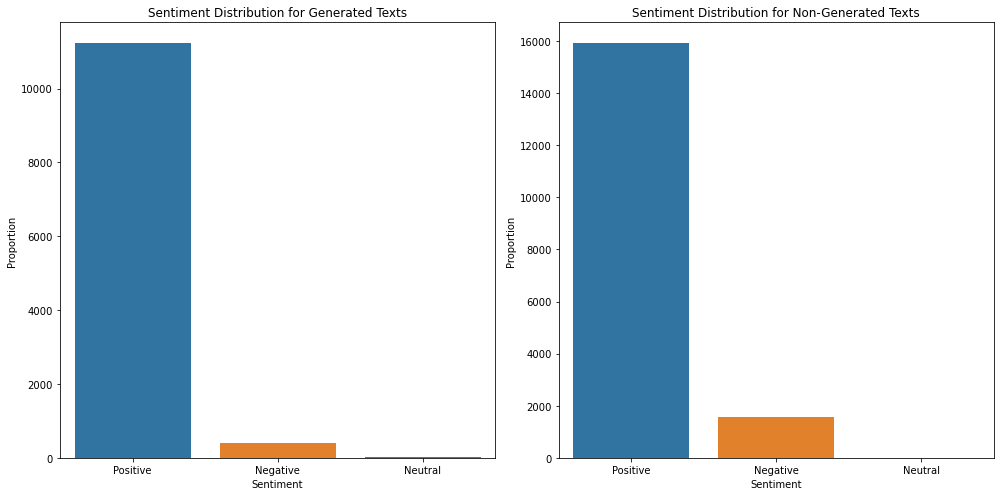

In [137]:
# Plot sentiment distribution
plt.figure(figsize=(14, 7))

# plt.subplot(1, 2, 1)
# sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
# plt.title('Overall Sentiment Distribution')
# plt.xlabel('Sentiment')
# plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# sns.barplot(x=sentiment_from_generated.index, y=sentiment_from_generated.values, alpha=0.7, label='Generated')
# sns.barplot(x=sentiment_from_non_generated.index, y=sentiment_from_non_generated.values, alpha=0.7, label='Non-Generated')
# plt.title('Sentiment Distribution: Generated vs Non-Generated')
# plt.xlabel('Sentiment')
# plt.ylabel('Count')
# plt.legend()


plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_from_generated.index, y=sentiment_from_generated.values)
plt.title('Sentiment Distribution for Generated Texts')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')

plt.subplot(1, 2, 2)
sns.barplot(x=sentiment_from_non_generated.index, y=sentiment_from_non_generated.values)
plt.title('Sentiment Distribution for Non-Generated Texts')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')


plt.tight_layout()
plt.show()

In [138]:
#for converting the text data into numerical format
from sklearn.feature_extraction.text import TfidfVectorizer

In [139]:
data = pd.read_csv('../dataset/cleaned_data.csv')
data.tail(10)

,text,generated
29135,sources focus advantages limiting car usage us...,0
29136,cars big part lives rely get point point need ...,0
29137,since world war heavily dependent modern day t...,0
29138,driving cars danger humans also threat earth u...,0
29139,studies shown passenger cars responsible perce...,0
29140,fuss elector college many people get confused ...,0
29141,limiting car usage many advantages putting lot...,0
29142,new trend developing years soon full throttle ...,0
29143,know cars big part society today however cars ...,0
29144,cars around since popular ever since although ...,0


In [140]:
#checking wether the dataset is balanced or imbalnaced using the predicted Label
label0_1= data['generated'].value_counts()

#Lets check further 
label_0= data['generated'].value_counts()[0]
label_1= data['generated'].value_counts()[1]

imbalance_ratio= label_0/label_1

print(label0_1)
print('The imblance ratio is: ', imbalance_ratio)

0    17508
1    11637
Name: generated, dtype: int64
The imblance ratio is:  1.5045114720288735


Label 0 appears approximately 1.5 times more frequently than Label 1, which indicates a **moderate imbalance**.

Thus, to balance the dataset we will use **SMOTE**.

In [141]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [142]:
X= data['text']
y= data['generated']

In [143]:
#To check whether data['text'] contains any null values or not
data['text'].isna().sum()

1

In [144]:
data['text'] = data['text'].fillna('')

In [145]:
#Vectorizing the texted data
tfidfvectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = tfidfvectorizer.fit_transform(X)

In [146]:
#Spilitting dataset into training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, f1_score, recall_score, precision_score

In [147]:
X_train, X_val, y_train, y_val= train_test_split(X_tfidf, y, test_size= 0.3, random_state= 42)

In [148]:
#Implementing SMOTE on imbalanced training dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

**Precision Recall Curve**

In [149]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [150]:
def plot_precision_recall_curve(y_val, y_val_proba,color, model_name):
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    auc_score = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, marker='*', color=color, label=f'{model_name} (AUC-PR = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend()
    plt.show()

**ROC Curve (Receiver Operating Characteristic Curve)**

In [151]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [152]:
def plot_roc_curve(y_val, y_val_proba,color, model_name):
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    auc = roc_auc_score(y_val, y_val_proba)
    plt.figure()
    plt.plot(fpr, tpr, marker='.', color= color, label=f'{model_name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.show()

**ML Model Building #1 - Random Forest Tree**

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf_model= RandomForestClassifier(random_state=45, max_depth=2)

In [154]:
#Fitting the model on training datasets
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=2, random_state=45)

In [155]:
#Predictions on training dataset
y_train_pred_rf= rf_model.predict(X_train_smote)

**Precision, Recall, F1-score and Accuracy - Random Forest Tree**

In [156]:
print('classification report of training dataset')
print('\n')
print(classification_report(y_train_smote, y_train_pred_rf))

classification report of training dataset


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12224
           1       0.97      0.90      0.94     12224

    accuracy                           0.94     24448
   macro avg       0.94      0.94      0.94     24448
weighted avg       0.94      0.94      0.94     24448



In [157]:
y_val_pred_rf= rf_model.predict(X_val)
print('classification report of Validation set')
print('\n')
print(classification_report(y_val, y_val_pred_rf))

classification report of Validation set


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5284
           1       0.96      0.89      0.92      3460

    accuracy                           0.94      8744
   macro avg       0.94      0.93      0.93      8744
weighted avg       0.94      0.94      0.94      8744



**Precision Recall Curve - Random Forest Tree**

In [158]:
y_val_proba_rf= rf_model.predict_proba(X_val)[:,1]

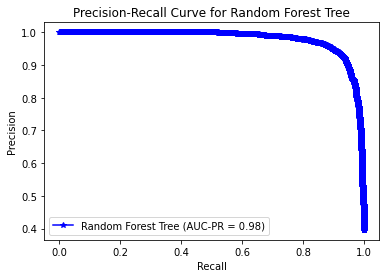

In [159]:
plot_precision_recall_curve(y_val, y_val_proba_rf,'b','Random Forest Tree')

**ROC Curve - Random Forest Tree (Receiver Operating Characteristic Curve)**

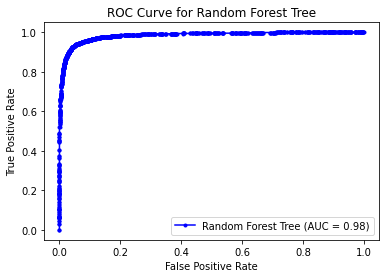

In [160]:
plot_roc_curve(y_val, y_val_proba_rf,'b', 'Random Forest Tree')

**ML Model Building #2 - XG Boost**

In [161]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: xgboost in c:\users\simra\anaconda3\lib\site-packages (2.1.0)



DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [162]:
from xgboost import XGBClassifier

In [163]:
XG_model= XGBClassifier()

In [164]:
XG_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [165]:
y_train_pred_XG= XG_model.predict(X_train_smote)

**Precision, Recall, F1-score and Accuracy - XGBoost**

In [166]:
print('classification report of training dataset')
print('\n')
print(classification_report(y_train_smote, y_train_pred_XG))

classification report of training dataset


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12224
           1       1.00      1.00      1.00     12224

    accuracy                           1.00     24448
   macro avg       1.00      1.00      1.00     24448
weighted avg       1.00      1.00      1.00     24448



In [167]:
y_val_pred_XG = XG_model.predict(X_val)
print('classification report of Validation set')
print('\n')
print(classification_report(y_val, y_val_pred_XG))

classification report of Validation set


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5284
           1       0.99      0.99      0.99      3460

    accuracy                           0.99      8744
   macro avg       0.99      0.99      0.99      8744
weighted avg       0.99      0.99      0.99      8744



**Precision Recall Curve - XGBoost**

In [168]:
y_val_proba_XG= XG_model.predict_proba(X_val)[:,1]

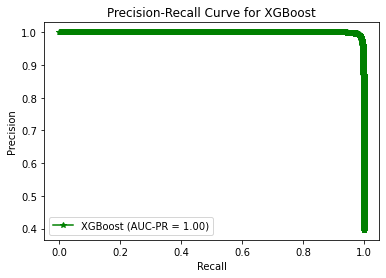

In [169]:
plot_precision_recall_curve(y_val, y_val_proba_XG,'g','XGBoost')

**ROC Curve - XGBoost (Receiver Operating Characteristic Curve)**

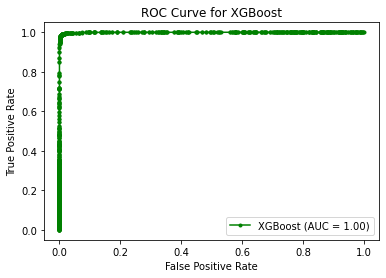

In [170]:
plot_roc_curve(y_val, y_val_proba_XG,'g', 'XGBoost')

**ML Model Building #3 - AdaBoost**

In [171]:
from sklearn.ensemble import AdaBoostClassifier

In [172]:
Ad_model= AdaBoostClassifier()

In [173]:
Ad_model.fit(X_train_smote, y_train_smote)

AdaBoostClassifier()

In [174]:
y_train_pred_Ad= Ad_model.predict(X_train_smote)

**Precision, Recall, F1-score and Accuracy - AdaBoost**

In [175]:
print('classification report of training dataset')
print('\n')
print(classification_report(y_train_smote, y_train_pred_Ad))

classification report of training dataset


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12224
           1       0.96      0.96      0.96     12224

    accuracy                           0.96     24448
   macro avg       0.96      0.96      0.96     24448
weighted avg       0.96      0.96      0.96     24448



In [176]:
y_val_pred_Ad = Ad_model.predict(X_val)
print('classification report of Validation set')
print('\n')
print(classification_report(y_val, y_val_pred_Ad))

classification report of Validation set


              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5284
           1       0.93      0.95      0.94      3460

    accuracy                           0.95      8744
   macro avg       0.95      0.95      0.95      8744
weighted avg       0.95      0.95      0.95      8744



**Precision Recall Curve - AdaBoost**

In [177]:
y_val_proba_Ad= Ad_model.predict_proba(X_val)[:,1]

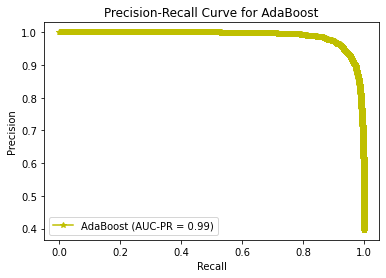

In [178]:
plot_precision_recall_curve(y_val, y_val_proba_Ad,'y','AdaBoost')

**ROC Curve - AdaBoost (Receiver Operating Characteristic Curve)**

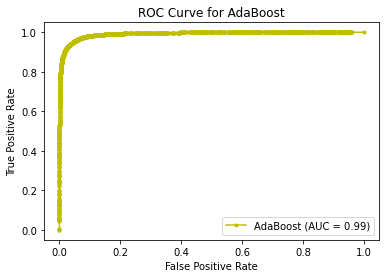

In [179]:
plot_roc_curve(y_val, y_val_proba_Ad,'y', 'AdaBoost')

In [180]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming you have your models and predictions ready
models = {
   
    'Random Forest': rf_model,
    'XGBoost': XG_model,
    'AdaBoost': Ad_model
}

metrics = {}

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    
    # ROC Curve and AUC-ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve and AUC-PR
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Precision, Recall, F1 Score, Accuracy
    precision_score_val = precision_score(y_val, y_pred)
    recall_score_val = recall_score(y_val, y_pred)
    f1_score_val = f1_score(y_val, y_pred)
    accuracy_score_val = accuracy_score(y_val, y_pred)
    
    # Store metrics
    metrics[name] = {
        'AUC-ROC': roc_auc,
        'AUC-PR': pr_auc,
        'Precision': precision_score_val,
        'Recall': recall_score_val,
        'F1 Score': f1_score_val,
        'Accuracy': accuracy_score_val
    }


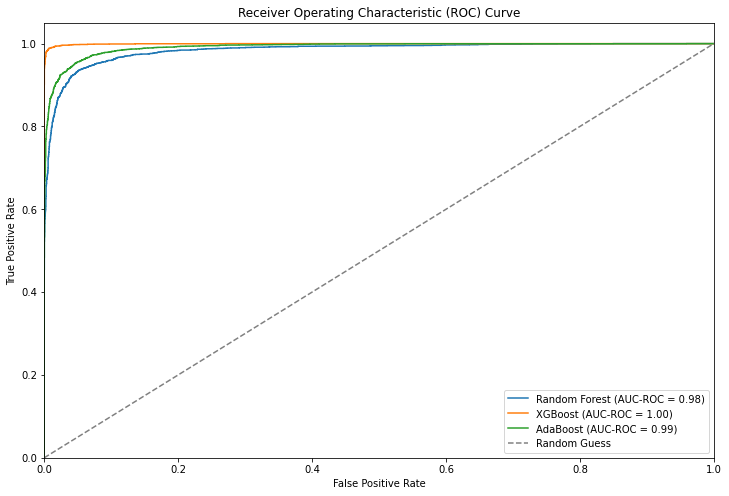

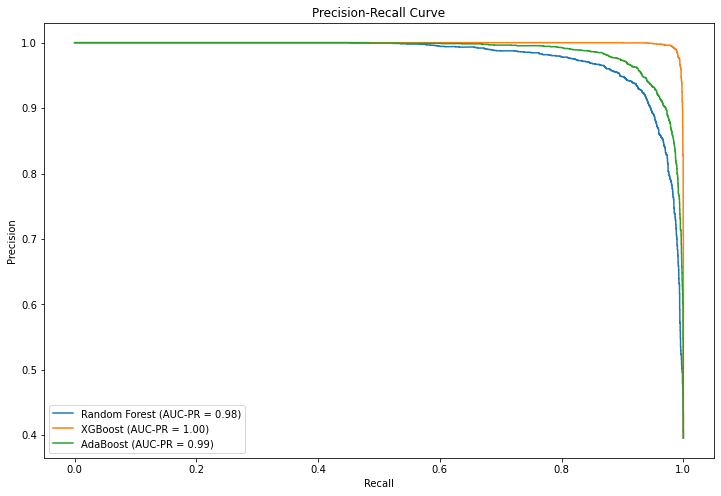

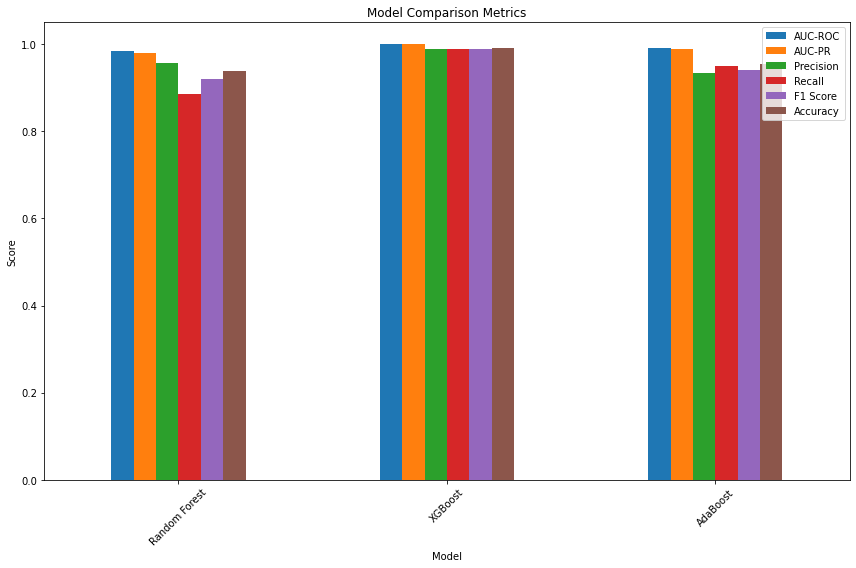

In [181]:
import matplotlib.pyplot as plt

# Plotting AUC-ROC
plt.figure(figsize=(12, 8))
for name, metric in metrics.items():
    fpr, tpr, _ = roc_curve(y_val, models[name].predict_proba(X_val)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC-ROC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plotting Precision-Recall Curve
plt.figure(figsize=(12, 8))
for name, metric in metrics.items():
    precision, recall, _ = precision_recall_curve(y_val, models[name].predict_proba(X_val)[:, 1])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC-PR = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# Plotting Precision, Recall, F1 Score, Accuracy
metrics_df = pd.DataFrame(metrics).T
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Comparison Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


**XGBoost Model outperformed it!**

As it can be seen above, XGBoost Model  is the best performer.
To validate this model,to see if it performs like it says it does.

So, to do that we are going to apply k-fold cross validation, where k=5.

In [182]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(XG_model, X_tfidf, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.2f}")


Cross-Validation Scores: [0.65963287 0.93909762 0.86447075 0.96483102 0.95196432]
Mean Cross-Validation Score: 0.88


From above, we can see that the scores represent the accuracy of model on each of the 5 folds.There is significant variation in the scores, with the lowest being approximately 0.659 and the highest being around 0.951.

The average accuracy across all 5 folds is 0.88, which indicates that on an average, the model performs well.

In [183]:
from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=5)
cross_val_scores_stratified = cross_val_score(XG_model, X_tfidf, y, cv=stratified_kfold, scoring='accuracy')

print(f"Stratified Cross-Validation Scores: {cross_val_scores_stratified}")
print(f"Mean Stratified Cross-Validation Score: {cross_val_scores_stratified.mean():.2f}")

Stratified Cross-Validation Scores: [0.65963287 0.93909762 0.86447075 0.96483102 0.95196432]
Mean Stratified Cross-Validation Score: 0.88


As Stratified K-fold is the enhanced version of K-fold cross validation, it helps to train and test the model on different subsets of the data while keeping the class distribution (EG: CLASS 0: 50%, CLASS 1: 5%) consistent across all folds. This makes sure that each fold is a good representation of the entire dataset, leading to more reliable performance metrics.

The results of the stratified k-fold cross-validation are the same as the previous cross-validation results, indicating a significant variability in the scores across different folds.

In [184]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost model
xgboost_model = xgb.XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_tfidf, y)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Best Cross-Validation Score: 0.88


After performing hyperparameter tuning,  we got best parameters: ['learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300] and best cross-validation score of 0.88.

**Interpretation of Results:**

1. Consistent Score:

The mean cross-validation score of 0.88 indicates that the model performs well on average across different folds. However, if the variability is high, it’s worth exploring further.

2. Best Parameters:

The parameters you found (learning_rate: 0.2, max_depth: 7, n_estimators: 300) suggest that a higher learning rate and deeper trees with more estimators are beneficial for this problem.

To furthermore delve into the XGBoost model and check the consistency of the model's performace, we will re-train the model using the best params, then re-evaluate the model and re-apply the cross-validation.

In [191]:
from xgboost import XGBClassifier

# Initialize the XGBoost model with the best parameters
best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
xgboost_model_best = XGBClassifier(**best_params, random_state=42)

# Train the model on the full training data
xgboost_model_best.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [197]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [198]:
y_train_pred_XG= xgboost_model_best.predict(X_train_smote)

In [199]:
print('classification report of training dataset')
print('\n')
print(classification_report(y_train_smote, y_train_pred_XG))


classification report of training dataset


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12224
           1       1.00      1.00      1.00     12224

    accuracy                           1.00     24448
   macro avg       1.00      1.00      1.00     24448
weighted avg       1.00      1.00      1.00     24448



In [200]:
y_val_pred_XG = xgboost_model_best.predict(X_val)
print('classification report of Validation set')
print('\n')
print(classification_report(y_val, y_val_pred_XG))

classification report of Validation set


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5284
           1       0.99      0.99      0.99      3460

    accuracy                           0.99      8744
   macro avg       0.99      0.99      0.99      8744
weighted avg       0.99      0.99      0.99      8744



In [201]:
#Performing cross-validation with the tuned model.
#Perform k-fold cross-validation again to evaluate the performance of the model with the tuned hyperparameters. 
#This helps to confirm that the changes have led to improvements in performance and that the model generalizes well.
from sklearn.model_selection import cross_val_score

cross_val_scores_best = cross_val_score(xgboost_model_best, X_tfidf, y, cv=5, scoring='accuracy')
print(f"Stratified Cross-Validation Scores with Best Parameters: {cross_val_scores_best}")
print(f"Mean Stratified Cross-Validation Score: {cross_val_scores_best.mean():.2f}")


Stratified Cross-Validation Scores with Best Parameters: [0.66803911 0.9442443  0.87424944 0.97186481 0.95985589]
Mean Stratified Cross-Validation Score: 0.88


Reasons of Re-Evaluating XGBoost Model with Best Params:

1. **Optimize Performance:** The hyperparameter tuning process aims to find the optimal settings for the model, which should ideally improve its performance. By evaluating the model with these best parameters, we can confirm if the tuning has indeed led to a performance boost.


2. **Compare Results:** After tuning, it's crucial to compare the new model's performance with the previous results. This will help to understand if the best parameters truly enhance the model's accuracy and other performance metrics.In this case, the results of new model (tuned model performance) and previous model performance (initial model performance) is same.


3. **Avoid Overfitting:** Sometimes, the tuned model may show improved performance on training data but still need to be validated on a separate validation set to ensure that it generalizes well.


Our updated results show that after hyperparameter tuning and re-evaluating the model, we have very high performance metrics for both training and validation datasets. Here’s a breakdown of the results:

***1. Classification Report***

**Training Dataset:**

* Precision, Recall, F1-Score: 1.00 for both classes (0 and 1)
* Accuracy: 1.00 (100%)
* This indicates that your model performs perfectly on the training data.

**Validation Dataset:**

* Precision, Recall, F1-Score: 0.99 for both classes (0 and 1)
* Accuracy: 0.99 (99%)
* This indicates that the model performs very well on unseen validation data, with only a slight drop compared to training performance.

***2. Stratified Cross-Validation Scores***

* Cross-Validation Scores: [0.66803911, 0.9442443, 0.87424944, 0.97186481, 0.95985589]
* Mean Score: 0.88

**<u> Interpretation:**

1. Training Performance:The model achieves perfect accuracy on the training dataset, which often suggests potential overfitting. However, this is not unusual, especially with well-tuned models.


2. Validation Performance: The model maintains very high accuracy (99%) on the validation dataset, indicating it generalizes well to new data. The metrics are consistent and high across precision, recall, and F1-score.


3. Cross-Validation Performance: The cross-validation scores, with a mean accuracy of 0.88, indicate that the model performs well across different folds of the data. The variation in scores (from ~0.67 to ~0.97) suggests some fluctuation in performance, which is typical, but overall the model's performance is strong.
    
  
    

Overall, the high performance metrics and consistent cross-validation scores suggest that the model, with the best parameters, is performing well.

**<u>Conclusion:**

Since, we have already undertaken rigorous evaluation and tuning of our XGBoost model. The steps above ensure that the model is not only well-optimized but also thoroughly tested for practical deployment. Continuing to monitor the model’s performance and adapting it as needed will help maintain its effectiveness in real-world scenarios.